In [1]:
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

train_x = torch.linspace(0, 1, 4)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2

In [2]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 100
warmup_steps = 2 if smoke_test else 100


from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = ExactGPModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(train_x, train_y)

Warmup:   0%|                                                                                | 0/200 [00:00, ?it/s]/home/jbris/.cache/pypoetry/virtualenvs/bo-deepgp-K7zYQhBX-py3.10/lib/python3.10/site-packages/torch/autograd/__init__.py:411: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Sample: 100%|█████████████████████████████████████| 200/200 [00:37,  5.27it/s, step size=4.14e-01, acc. prob=0.968]


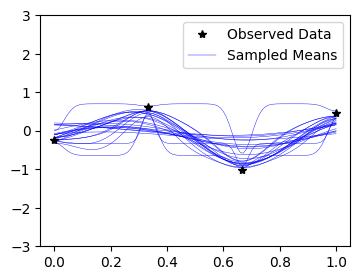

In [3]:
model.pyro_load_from_samples(mcmc_run.get_samples())

model.eval()
test_x = torch.linspace(0, 1, 101).unsqueeze(-1)
test_y = torch.sin(test_x * (2 * math.pi))
expanded_test_x = test_x.unsqueeze(0).repeat(num_samples, 1, 1)
output = model(expanded_test_x)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Sampled Means'])

In [ ]:
import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

from sklearn.datasets import make_regression

X, y = make_regression(n_samples=4, n_features=2, noise=1, random_state=42)
train_x = torch.Tensor(X)
train_y = torch.Tensor(y)

data_dim = train_x.size(-1)

class FeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(data_dim, 8))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(8, 1))
        
feature_extractor = FeatureExtractor()

class DKLModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(DKLModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        self.feature_extractor = feature_extractor
        self.scale_to_bounds = gpytorch.utils.grid.ScaleToBounds(-1., 1.)
        
    def forward(self, x):
        projected_x = self.feature_extractor(x)
        projected_x = self.scale_to_bounds(projected_x)   
        
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
num_samples = 2 if smoke_test else 200
warmup_steps = 2 if smoke_test else 200


from gpytorch.priors import LogNormalPrior, NormalPrior, UniformPrior
# Use a positive constraint instead of usual GreaterThan(1e-4) so that LogNormal has support over full range.
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Positive())
model = DKLModel(train_x, train_y, likelihood)

model.mean_module.register_prior("mean_prior", UniformPrior(-1, 1), "constant")
model.covar_module.base_kernel.register_prior("lengthscale_prior", UniformPrior(0.01, 0.5), "lengthscale")
model.covar_module.register_prior("outputscale_prior", UniformPrior(1, 2), "outputscale")
likelihood.register_prior("noise_prior", UniformPrior(0.01, 0.5), "noise")

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def pyro_model(x, y):
    with gpytorch.settings.fast_computations(False, False, False):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        pyro.sample("obs", output, obs=y)
    return y

nuts_kernel = NUTS(pyro_model)
mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, disable_progbar=smoke_test)
mcmc_run.run(train_x, train_y)

Warmup:  40%|██████████████▉                      | 162/400 [01:01,  6.03it/s, step size=1.38e-01, acc. prob=0.773]

In [ ]:
model.pyro_load_from_samples(mcmc_run.get_samples())

model.eval()
output = model(train_x)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*', zorder=10)

    for i in range(min(num_samples, 25)):
        # Plot predictive means as blue line
        ax.plot(train_x.numpy(), output.mean[i].detach().numpy(), 'b', linewidth=0.3)

    # Shade between the lower and upper confidence bounds
    # ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Sampled Means'])

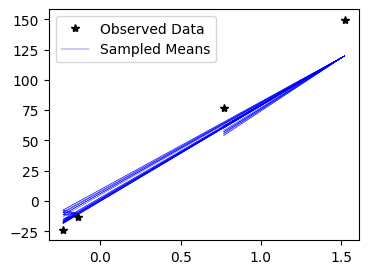

In [67]:
# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(4, 3))

x = train_x.T[0].numpy()
y = train_y.numpy()
# Plot training data as black stars
ax.plot(x, y, 'k*', zorder=10)

for i in range(min(num_samples, 25)):
    # Plot predictive means as blue line
    ax.plot(x, output.mean[i].detach().numpy(), 'b', linewidth=0.3)

# Shade between the lower and upper confidence bounds
# ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Sampled Means'])

tensor([-0.1383, -0.2341,  1.5230,  0.7674])